In [3]:
import numpy as np
from numpy import pi,exp,sin,cos
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [4]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


In [5]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [6]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [25]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = xTarget.copy() # np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[i] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

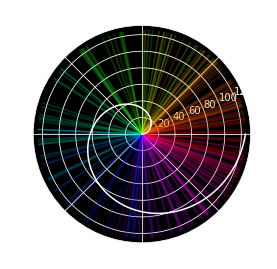

In [26]:
# show time course
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

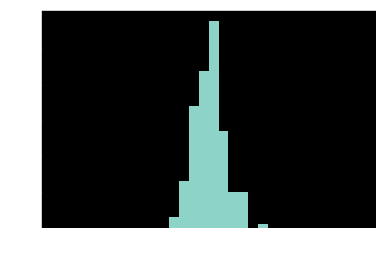

In [27]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


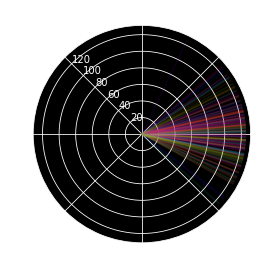

In [28]:
# show time course of error
from matplotlib.cm import hsv
ax = plt.subplot(projection='polar')
for dxi_t,target in zip(errors,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(dxi_t,t,color=color,alpha=0.1)
ax.set_ylabel('time')
ax.set_rlabel_position(135)


In [29]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = xTarget.copy() # np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[i] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': 0*W, # 'feedforward'
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

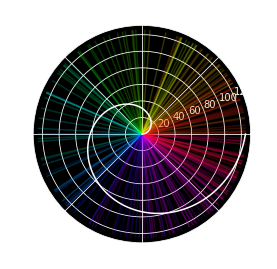

In [30]:
# show time course
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

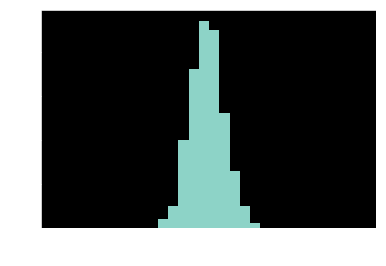

In [31]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


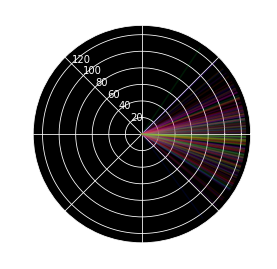

In [32]:
# show time course of error
from matplotlib.cm import hsv
ax = plt.subplot(projection='polar')
for dxi_t,target in zip(errors,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(dxi_t,t,color=color,alpha=0.1)
ax.set_ylabel('time')
ax.set_rlabel_position(135)


In [33]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = xTarget.copy() # np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[i] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': 0, # k_cue, # 'no external field'
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

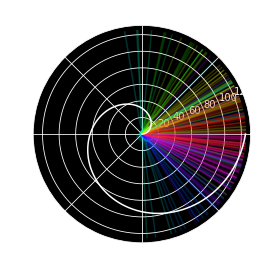

In [34]:
# show time course
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

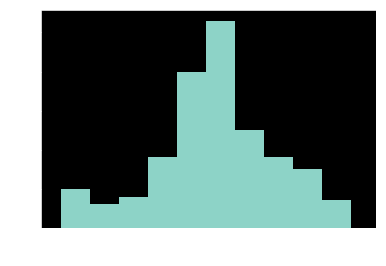

In [35]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


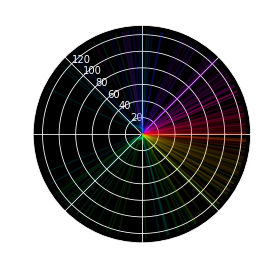

In [36]:
# show time course of error
from matplotlib.cm import hsv
ax = plt.subplot(projection='polar')
for dxi_t,target in zip(errors,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(dxi_t,t,color=color,alpha=0.1)
ax.set_ylabel('time')
ax.set_rlabel_position(135)


In [37]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = np.random.vonmises(0,k_prior,N)
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[i] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': 0, # k_cue, # 'no external field' + 'random initialization'
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

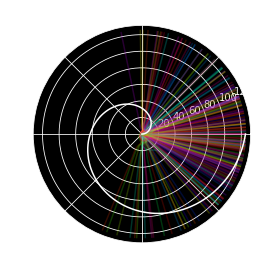

In [38]:
# show time course
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

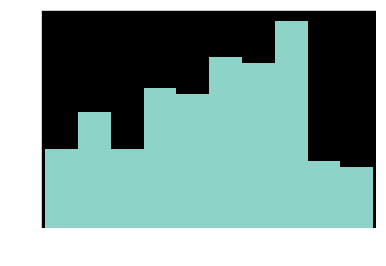

In [39]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


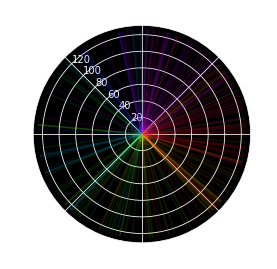

In [40]:
# show time course of error
from matplotlib.cm import hsv
ax = plt.subplot(projection='polar')
for dxi_t,target in zip(errors,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(dxi_t,t,color=color,alpha=0.1)
ax.set_ylabel('time')
ax.set_rlabel_position(135)
